# Predicción de Ingresos — Resumen Ejecutivo

Objetivo: construir y evaluar un Random Forest que clasifique si una persona gana >50K/año, mostrando buenas prácticas en limpieza, EDA, transformaciones, modelo Random Forest y evaluación.

Datos: Adult Income Dataset (UCI). Fuente: https://archive.ics.uci.edu/dataset/2/adult

Notas rápidas:
- Contenido del proyecto, dependencias y versiones en `README.md` / `environment.yml`.
- Celdas costosas marcadas con "Nota: puede tardar".

## Carga de datos, librerías y primera inspección
Se carga el dataset con las librerias a usar en el notebook y se realiza una inspección inicial (info, head) para entender su estructura y tamaño.

In [20]:
# Limpieza y análisis de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ajuste de los datos
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

# Creación del modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Evaluación del modelo
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Palette = ['#1f78b4','#b2df8a']
sns.set_palette(Palette)

%run pandas-missing-extension.ipynb

df = pd.read_csv('https://archive.ics.uci.edu/static/public/20/data.csv', sep = ',')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Limpieza de Datos
### Valores Nulos

In [21]:
df.missing.missing_variable_summary()
cols_missing = ['workclass', 'occupation', 'native-country']

for col in cols_missing:
    print(f'Valores únicos de {col}:', df[col].unique())
    print('=' * 50)

Valores únicos de workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
Valores únicos de occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]
Valores únicos de native-country: ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Holand-Netherlands' nan]


Al ver los valores únicos de cada columna, vemos que los valores faltantes están nombrados como "?" y "nan", entonces los reemplazamos por np.nan para tenerlos en una misma categoría.

In [22]:
df.replace('?', np.nan, inplace=True)
df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,age,0,48842,0.000000
1,workclass,2799,48842,5.730724
2,fnlwgt,0,48842,0.000000
3,education,0,48842,0.000000
4,education-num,0,48842,0.000000
5,marital-status,0,48842,0.000000
6,occupation,2809,48842,5.751198
7,relationship,0,48842,0.000000
8,race,0,48842,0.000000
9,sex,0,48842,0.000000


Vemos cómo los valores nulos en cada columna aumentaron en gran cantidad después de hacer el reemplazo. Ahora, lo que se hará será hacer otra imputación, pero esta vez convirtiendo los valores faltantes categóricos en una nueva categoría llamada `"Unknown"`, así no se pierde información y se puede seguir trabajando con esos datos.

In [23]:
df['workclass'] = df['workclass'].fillna('Unknown')
df['occupation'] = df['occupation'].fillna('Unknown')
df['native-country'] = df['native-country'].fillna('Unknown')
df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,age,0,48842,0.0
1,workclass,0,48842,0.0
2,fnlwgt,0,48842,0.0
3,education,0,48842,0.0
4,education-num,0,48842,0.0
5,marital-status,0,48842,0.0
6,occupation,0,48842,0.0
7,relationship,0,48842,0.0
8,race,0,48842,0.0
9,sex,0,48842,0.0


### Valores Duplicados

In [24]:
num_duplicados = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicados}")

Número de filas duplicadas: 29


Al ver que no son tantos datos duplicados, procedemos a eliminarlos ya que no afectará mucho el dataset y puede ayudar a mejorar el rendimiento del modelo.

In [25]:
df = df.drop_duplicates()
print(f"Número de filas duplicadas: {df.duplicated().sum()}")

df_processing = df.copy()

Número de filas duplicadas: 0


Finalmente, copiamos el dataframe limpio a una nueva variable para seguir trabajando con ella y no perder el dataframe original.

## Análisis Exploratorio de Datos (EDA)

### Análisis de Variable objetivo: `income`

Como primera parte del EDA, se realiza un análisis del dataset para entender las estadísticas descriptivas de las variables numéricas.

In [26]:
df_processing.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48813.000000,4.881300e+04,48813.000000,48813.000000,48813.000000,48813.000000
mean,38.647348,1.896679e+05,10.078688,1079.708705,87.554299,40.425051
std,13.709005,1.056062e+05,2.570257,7454.185982,403.118605,12.390954
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781400e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376200e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Notamos que en las variables 'capital-gain' y 'capital-loss' hay una inconsistencia entre su rango intercuartílico y su valor máximo, lo que indica que hay muchos valores atípicos en esas variables.

In [27]:
df_processing['income'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

Vemos que la variable objetivo tiene cuatro valores únicos, pero solamente deberían ser dos (<=50K y >50K). Entonces, procedemos a unificar los valores que son similares para tener solamente dos categorías y mostrar la cantidad de valores que hay en cada categoria.

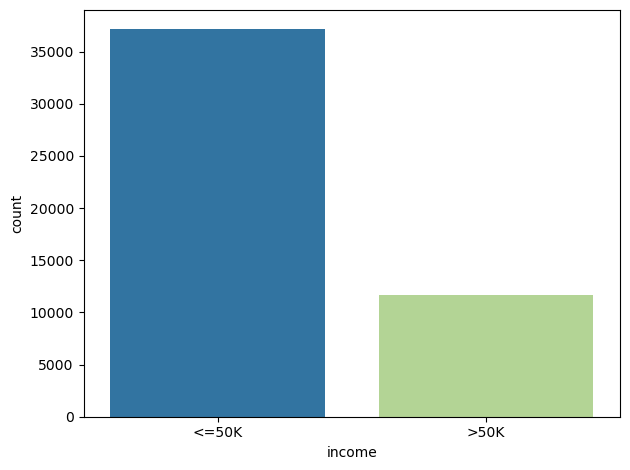

In [28]:
df_processing['income'] = df_processing['income'].str.strip('.')

sns.countplot(data=df_processing, x='income', hue='income')
plt.tight_layout()
plt.show()

Al hacer la unificación y ver la distribución de la variable objetivo, vemos que hay un desbalance en las clases, ya que la mayoría de los datos pertenecen a la clase <=50K. Para entender mejor cómo las variables numéricas se relacionan con este desbalance, analizaremos:

1. La distribución de edades por nivel de ingreso mediante un gráfico KDE, que nos mostrará si existen patrones o tendencias en la edad para cada grupo de ingreso.

2. La distribución de horas trabajadas por semana mediante un violin plot, que nos permitirá visualizar no solo la mediana y el rango, sino también la forma completa de la distribución para cada nivel de ingreso.

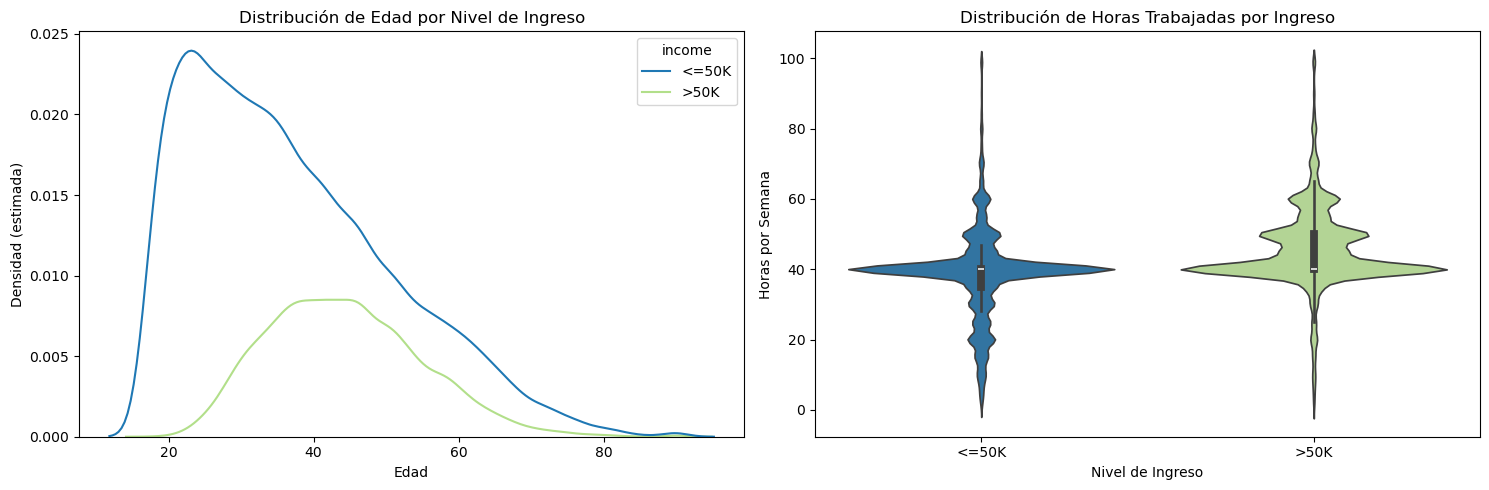

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# KDE plot para edad por ingreso
sns.kdeplot(data=df_processing, x='age', hue='income', ax=ax1)
ax1.set_title('Distribución de Edad por Nivel de Ingreso')
ax1.set_xlabel('Edad')
ax1.set_ylabel('Densidad (estimada)')

# Violin plot para horas trabajadas
sns.violinplot(data=df_processing, x='income', y='hours-per-week', hue='income',
               ax=ax2, palette=Palette, legend=False)
ax2.set_title('Distribución de Horas Trabajadas por Ingreso')
ax2.set_xlabel('Nivel de Ingreso')
ax2.set_ylabel('Horas por Semana')

plt.tight_layout()
plt.show()

**Distribución de Edad (KDE Plot):**
- Las personas con ingresos <=50K son mayoría y su distribución se concentra entre los 20 y 40 años, con un pico pronunciado alrededor de los 25 años.
- Las personas con ingresos >50K presentan una distribución desplazada hacia la derecha, con mayor densidad entre 35 y 55 años, y prácticamente inexistente en edades muy jóvenes.
- Esto sugiere que los ingresos altos son más comunes en edades medias, probablemente debido a la acumulación de experiencia laboral.

**Distribución de Horas Trabajadas (Violin Plot):**
- Ambos grupos presentan una concentración fuerte alrededor de 40 horas semanales, lo cual coincide con una jornada laboral estándar.
- Sin embargo, el grupo >50K muestra una distribución más extendida hacia valores altos (más de 50 horas), indicando que quienes ganan más tienden a trabajar más horas.
- En cambio, el grupo <=50K tiene una mayor dispersión hacia abajo (menos de 40 horas), reflejando posiblemente empleos de medio tiempo o menos estables.

Estas visualizaciones sugieren que tanto la edad como las horas trabajadas son factores importantes que pueden influir en el nivel de ingresos de una persona. Ahora, para un análisis completo, continuaremos con las variables categóricas, ya que, estas son mayoría en este dataset y tienen alta cardinalidad.

## Análisis de Variables Categóricas

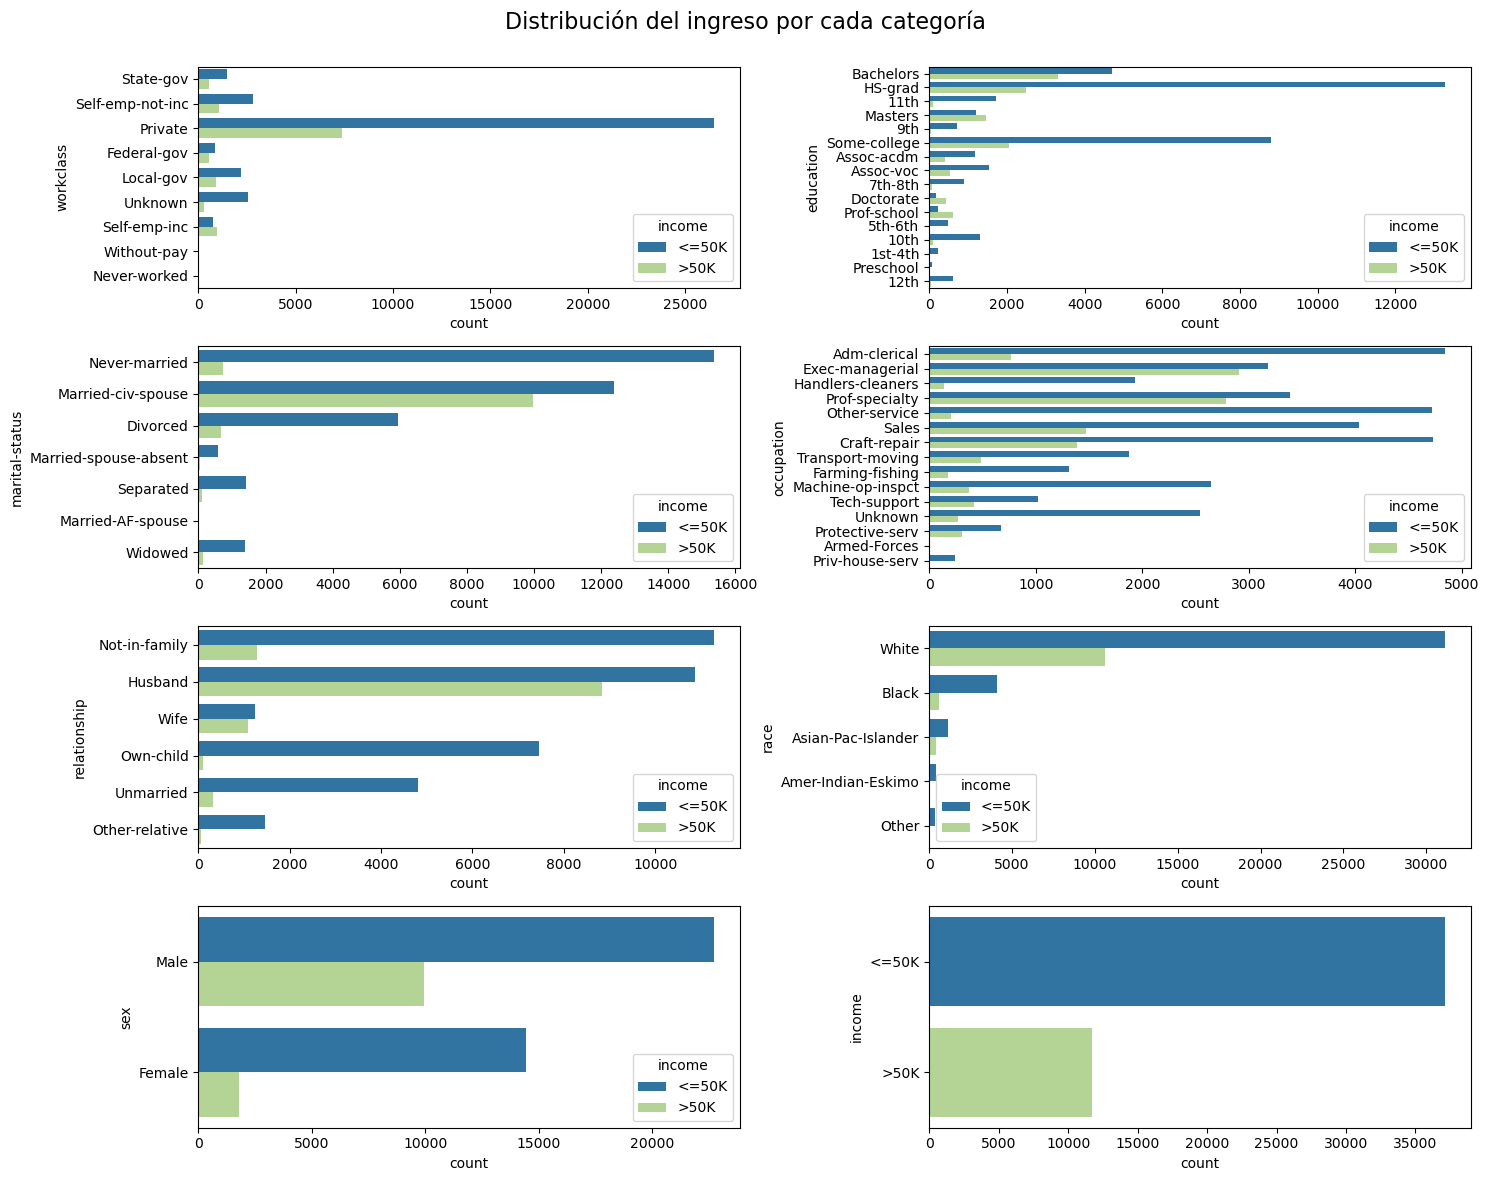

In [32]:
cols_categorical = df_processing.select_dtypes(include='object').drop('native-country', axis=1)
fig, ax = plt.subplots(4,2, figsize=(15,12))
for col, i in zip(cols_categorical, ax.flatten()):
    sns.countplot(data=df_processing, y=col, ax=i, hue='income')

fig.suptitle('Distribución del ingreso por cada categoría\n', fontsize=16)
plt.tight_layout()
plt.show()

Notamos que muchas de las variables categóricas tienen un número elevado de categorías, lo que puede complicar la codificación y el modelado. En este análisis hemos incluido todas las variables categóricas excepto `native-country`, que se ha excluido temporalmente debido a su alta cardinalidad (la trataremos por separado con técnicas apropiadas como Target Encoding).

Además, se observa de forma consistente que la clase `>50K` aparece con mucha menos frecuencia dentro de cada categoría, lo que confirma y refuerza el desbalance de la variable objetivo que ya habíamos detectado.

A continuación procederemos a analizar las variables numéricas para estudiar sus distribuciones y detectar outliers. Para ello utilizaremos boxplots por nivel de ingreso y, cuando proceda, transformaciones (ej. recorte por IQR) para decidir el tratamiento más apropiado.